In [ ]:
!pip install pyportfolioopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns, plotting
import numpy as np
import matplotlib.pyplot as plt
import pypfopt

In [ ]:
url = "https://raw.githubusercontent.com/robertmartin8/PyPortfolioOpt/master/cookbook/data/stock_prices.csv"
df = pd.read_csv(url, parse_dates=True, index_col="date")
df.head(5)

,GOOG,AAPL,FB,BABA,AMZN,GE,AMD,WMT,BAC,GM,T,UAA,SHLD,XOM,RRC,BBY,MA,PFE,JPM,SBUX
date,,,,,,,,,,,,,,,,,,,,
1989-12-29,NaN,0.117203,NaN,NaN,NaN,0.352438,3.9375,3.486070,1.752478,NaN,2.365775,NaN,NaN,1.766756,NaN,0.166287,NaN,0.110818,1.827968,NaN
1990-01-02,NaN,0.123853,NaN,NaN,NaN,0.364733,4.1250,3.660858,1.766686,NaN,2.398184,NaN,NaN,1.766756,NaN,0.173216,NaN,0.113209,1.835617,NaN
1990-01-03,NaN,0.124684,NaN,NaN,NaN,0.364050,4.0000,3.660858,1.780897,NaN,2.356516,NaN,NaN,1.749088,NaN,0.194001,NaN,0.113608,1.896803,NaN
1990-01-04,NaN,0.125100,NaN,NaN,NaN,0.362001,3.9375,3.641439,1.743005,NaN,2.403821,NaN,NaN,1.731422,NaN,0.190537,NaN,0.115402,1.904452,NaN
1990-01-05,NaN,0.125516,NaN,NaN,NaN,0.358586,3.8125,3.602595,1.705114,NaN,2.287973,NaN,NaN,1.722587,NaN,0.190537,NaN,0.114405,1.912100,NaN


# Calculate basic portfolio performance

In [ ]:
# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

In [ ]:
# Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
ef.portfolio_performance(verbose=True)

Expected annual return: 21.2%
Annual volatility: 9.8%
Sharpe Ratio: 1.96


(0.2122603544449754, 0.09809782819318544, 1.9598839035085913)

# Plotting - Unconstrained

In [ ]:
from pypfopt import CLA, plotting

cla = CLA(mu, S)
cla.max_sharpe()
cla.portfolio_performance(verbose=True);

Expected annual return: 29.9%
Annual volatility: 21.8%
Sharpe Ratio: 1.28


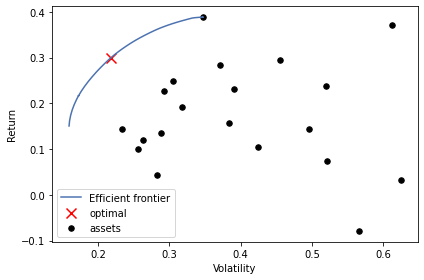

In [ ]:
ax = plotting.plot_efficient_frontier(cla, showfig=False)

# Plotting - Constrained

In [ ]:
import cvxpy as cp

mu = expected_returns.capm_return(df)
S = risk_models.CovarianceShrinkage(df).ledoit_wolf()

ef = EfficientFrontier(mu, S,)
big_tech_indices = [t in {"MSFT", "AMZN", "AAPL"} for t in df.columns]
ef.add_constraint(lambda w: cp.sum(w[big_tech_indices]) <= 0.3)

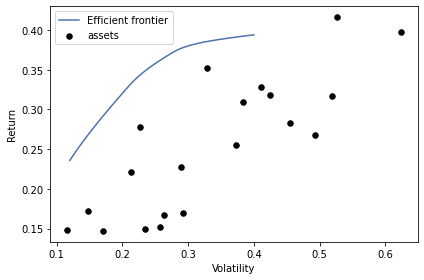

In [ ]:
ax = plotting.plot_efficient_frontier(ef, ef_param="risk", 
                                      ef_param_range=np.linspace(0.12, 0.4, 50), 
                                      showfig=False);

# Complex plots

In this example, we will plot the efficient frontier as well as 10,000 simulated portfolios.

To generate the simulated portfolios, we will sample random weights from the Dirichlet distribution (these are already normalized):

In [ ]:
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt((w.T * (S @ w.T)).sum(axis=0))
sharpes = rets / stds

print("Sample portfolio returns:", rets)
print("Sample portfolio volatilities:", stds)

Sample portfolio returns: [0.16357806 0.15223903 0.18779785 ... 0.1851787  0.18268064 0.16194018]
Sample portfolio volatilities: 0       0.234679
1       0.214214
2       0.219650
3       0.232805
4       0.203073
          ...   
9995    0.210308
9996    0.210768
9997    0.213836
9998    0.235507
9999    0.226741
Length: 10000, dtype: float64


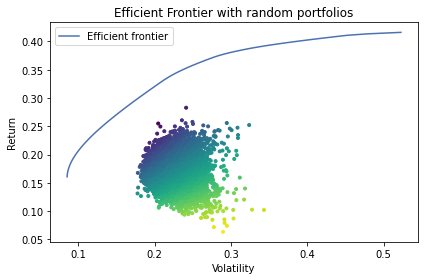

In [ ]:

# Plot efficient frontier with Monte Carlo sim
ef = EfficientFrontier(mu, S)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu, S)
ef2.max_sharpe()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()

# Plot random portfolios
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Format
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.show()


# Risk models

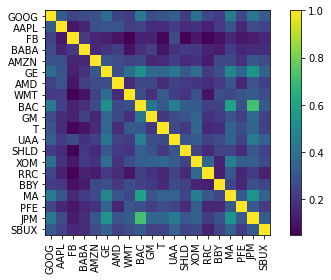

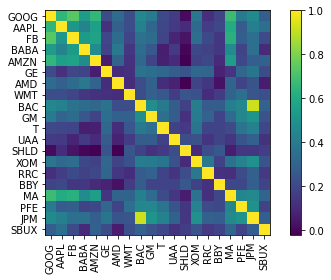

In [ ]:
past_df, future_df = df.iloc[:-250], df.iloc[-250:]
future_cov = risk_models.sample_cov(future_df)

sample_cov = risk_models.sample_cov(past_df)
plotting.plot_covariance(sample_cov, plot_correlation=True)
plotting.plot_covariance(future_cov, plot_correlation=True)
plt.show()

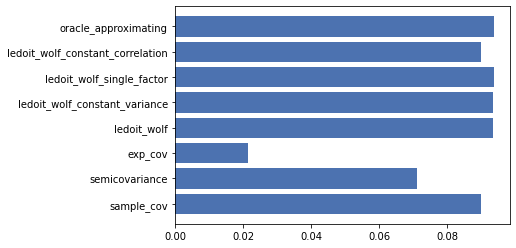

In [ ]:
future_variance = np.diag(future_cov)
mean_abs_errors = []

risk_methods = [
    "sample_cov",
    "semicovariance",
    "exp_cov",
    "ledoit_wolf",
    "ledoit_wolf_constant_variance",
    "ledoit_wolf_single_factor",
    "ledoit_wolf_constant_correlation",
    "oracle_approximating",
]

for method in risk_methods:
    S = risk_models.risk_matrix(df, method=method)
    variance = np.diag(S)
    mean_abs_errors.append(np.sum(np.abs(variance - future_variance)) / len(variance))
    
xrange = range(len(mean_abs_errors))
plt.barh(xrange, mean_abs_errors)
plt.yticks(xrange, risk_methods)
plt.show()

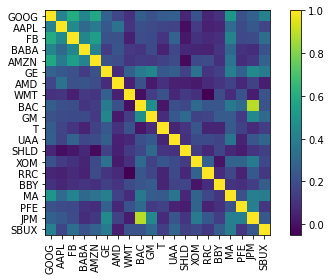

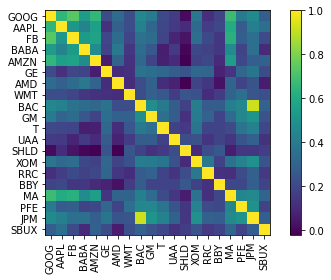

In [ ]:

exp_cov = risk_models.exp_cov(past_df)
plotting.plot_covariance(exp_cov, plot_correlation=True)
plotting.plot_covariance(future_cov, plot_correlation=True)
plt.show()

# Returns model

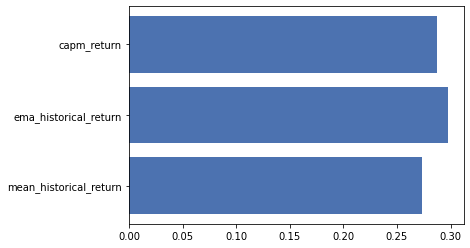

In [ ]:
future_rets = expected_returns.mean_historical_return(future_df)
mean_abs_errors = []
return_methods = [
    "mean_historical_return",
    "ema_historical_return",
    "capm_return",
    ]

for method in return_methods:
    mu = expected_returns.return_model(past_df, method=method)
    mean_abs_errors.append(np.sum(np.abs(mu - future_rets)) / len(mu))
    
xrange = range(len(mean_abs_errors))
plt.barh(xrange, mean_abs_errors)
plt.yticks(xrange, return_methods)
plt.show()

In [ ]:
print(mean_abs_errors)

[0.2732675295106071, 0.29740354389638524, 0.28701847303235856]


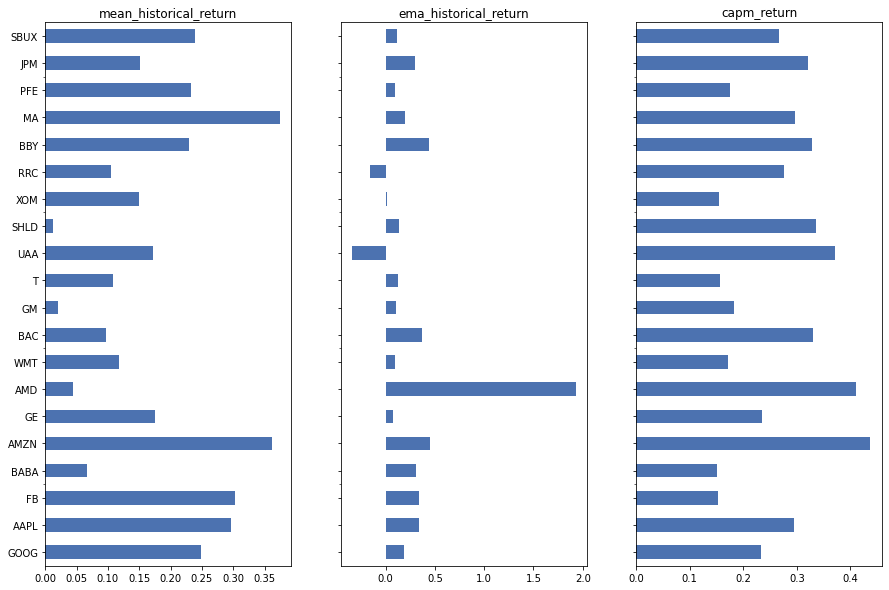

In [ ]:
fig, axs = plt.subplots( 1, len(return_methods),sharey=True, figsize=(15,10))

for i, method in enumerate(return_methods):
    mu = expected_returns.return_model(past_df, method=method)
    axs[i].set_title(method)
    mu.plot.barh(ax=axs[i])

# Advanced mean variance optimization

In [ ]:
import cvxpy as cp

# Note: functions are minimised. If you want to maximise an objective, stick a minus sign in it.
def logarithmic_barrier_objective(w, cov_matrix, k=0.1):
    log_sum = cp.sum(cp.log(w))
    var = cp.quad_form(w, cov_matrix)
    return var - k * log_sum

In [ ]:
ef = EfficientFrontier(mu, S, weight_bounds=(0.01, 0.2))
ef.convex_objective(logarithmic_barrier_objective, cov_matrix=S, k=0.001)
weights = ef.clean_weights()
weights

OrderedDict([('GOOG', 0.05106),
             ('AAPL', 0.02517),
             ('FB', 0.12902),
             ('BABA', 0.2),
             ('AMZN', 0.02172),
             ('GE', 0.02946),
             ('AMD', 0.0175),
             ('WMT', 0.04568),
             ('BAC', 0.01934),
             ('GM', 0.11979),
             ('T', 0.04669),
             ('UAA', 0.03281),
             ('SHLD', 0.03105),
             ('XOM', 0.04478),
             ('RRC', 0.02641),
             ('BBY', 0.02255),
             ('MA', 0.04644),
             ('PFE', 0.04109),
             ('JPM', 0.02101),
             ('SBUX', 0.02843)])

In [ ]:
ef.portfolio_performance(verbose=True)

Expected annual return: 20.8%
Annual volatility: 11.4%
Sharpe Ratio: 1.64


In [ ]:
# Another example of deviation risk parity
def deviation_risk_parity(w, cov_matrix):
    n = cov_matrix.shape[0]
    rp = (w * (cov_matrix @ w)) / cp.quad_form(w, cov_matrix)
    return cp.sum_squares(rp - 1 / n).value

ef = EfficientFrontier(mu, S)
ef.nonconvex_objective(deviation_risk_parity, ef.cov_matrix)
weights = ef.clean_weights()
weights

OrderedDict([('GOOG', 0.05427),
             ('AAPL', 0.02932),
             ('FB', 0.11303),
             ('BABA', 0.16708),
             ('AMZN', 0.02588),
             ('GE', 0.03384),
             ('AMD', 0.02132),
             ('WMT', 0.04845),
             ('BAC', 0.02347),
             ('GM', 0.10209),
             ('T', 0.04944),
             ('UAA', 0.03767),
             ('SHLD', 0.03561),
             ('XOM', 0.04809),
             ('RRC', 0.03079),
             ('BBY', 0.02661),
             ('MA', 0.05016),
             ('PFE', 0.04492),
             ('JPM', 0.02517),
             ('SBUX', 0.03279)])

In [ ]:

# Deviation risk parity with weight bound on the first asset
ef = EfficientFrontier(mu, S)
ef.nonconvex_objective(deviation_risk_parity, 
                       ef.cov_matrix, 
                       constraints=[{"type":"eq", "fun":lambda w: w[0] - 0.1}])
weights = ef.clean_weights()
weights

OrderedDict([('GOOG', 0.1),
             ('AAPL', 0.02962),
             ('FB', 0.10312),
             ('BABA', 0.13832),
             ('AMZN', 0.02623),
             ('GE', 0.03459),
             ('AMD', 0.02242),
             ('WMT', 0.0489),
             ('BAC', 0.02411),
             ('GM', 0.09282),
             ('T', 0.0489),
             ('UAA', 0.03734),
             ('SHLD', 0.03608),
             ('XOM', 0.04718),
             ('RRC', 0.03139),
             ('BBY', 0.02772),
             ('MA', 0.04683),
             ('PFE', 0.04516),
             ('JPM', 0.02594),
             ('SBUX', 0.03334)])

In [ ]:
# Market-neutral efficient risk.
# Please use ef.efficient_risk() for anything serious.
target_risk = 0.19
ef = EfficientFrontier(mu, S, weight_bounds=(None, None))

# Weights sum to zero
weight_constr = {"type": "eq", "fun": lambda w: np.sum(w)}

# Portfolio vol less than target vol
risk_constr = {
    "type": "eq",
    "fun": lambda w: target_risk ** 2 - np.dot(w.T, np.dot(ef.cov_matrix, w)),
}
constraints = [weight_constr, risk_constr]

ef.nonconvex_objective(
    lambda w, mu: -w.T.dot(mu),  # min negative return i.e max return
    objective_args=(ef.expected_returns),
    weights_sum_to_one=False,
    constraints=constraints,
)
weights = ef.clean_weights()
weights

OrderedDict([('GOOG', -0.00364),
             ('AAPL', 0.02772),
             ('FB', -0.18995),
             ('BABA', -0.2356),
             ('AMZN', 0.12412),
             ('GE', -0.03347),
             ('AMD', 0.06139),
             ('WMT', -0.09186),
             ('BAC', 0.01911),
             ('GM', -0.08287),
             ('T', -0.13896),
             ('UAA', 0.25523),
             ('SHLD', 0.10698),
             ('XOM', -0.25078),
             ('RRC', 0.04518),
             ('BBY', 0.03793),
             ('MA', 0.31288),
             ('PFE', -0.0491),
             ('JPM', 0.07778),
             ('SBUX', 0.0079)])

In [ ]:
# Utility objective - you could actually use ef.max_quadratic_utility
ef = EfficientFrontier(mu, S)

def utility_obj(weights, mu, cov_matrix, k=1):
    return -weights.dot(mu) + k * np.dot(weights.T, np.dot(cov_matrix, weights))

ef.nonconvex_objective(
    utility_obj,
    objective_args=(ef.expected_returns, ef.cov_matrix, 1)
    # default is for weights to sum to 1
)

weights = ef.clean_weights()
weights
     

OrderedDict([('GOOG', 0.0),
             ('AAPL', 0.0),
             ('FB', 0.0),
             ('BABA', 0.0),
             ('AMZN', 0.24615),
             ('GE', 0.0),
             ('AMD', 0.11846),
             ('WMT', 0.0),
             ('BAC', 0.0),
             ('GM', 0.0),
             ('T', 0.0),
             ('UAA', 0.41766),
             ('SHLD', 0.1358),
             ('XOM', 0.0),
             ('RRC', 0.0),
             ('BBY', 0.01505),
             ('MA', 0.06689),
             ('PFE', 0.0),
             ('JPM', 0.0),
             ('SBUX', 0.0)])

In [ ]:

# Kelly objective with weight bounds on zeroth asset
def kelly_objective(w, e_returns, cov_matrix, k=3):
    variance = np.dot(w.T, np.dot(cov_matrix, w))
    objective = variance * 0.5 * k - np.dot(w, e_returns)
    return objective

lower_bounds, upper_bounds = 0.01, 0.3
ef = EfficientFrontier(mu, S)
ef.nonconvex_objective(
    kelly_objective,
    objective_args=(ef.expected_returns, ef.cov_matrix, 1000),
    constraints=[
        {"type": "eq", "fun": lambda w: np.sum(w) - 1},
        {"type": "ineq", "fun": lambda w: w[0] - lower_bounds},
        {"type": "ineq", "fun": lambda w: upper_bounds - w[0]},
    ],
)

weights = ef.clean_weights()
weights

OrderedDict([('GOOG', 0.05),
             ('AAPL', 0.05),
             ('FB', 0.05),
             ('BABA', 0.05),
             ('AMZN', 0.05),
             ('GE', 0.05),
             ('AMD', 0.05),
             ('WMT', 0.05),
             ('BAC', 0.05),
             ('GM', 0.05),
             ('T', 0.05),
             ('UAA', 0.05),
             ('SHLD', 0.05),
             ('XOM', 0.05),
             ('RRC', 0.05),
             ('BBY', 0.05),
             ('MA', 0.05),
             ('PFE', 0.05),
             ('JPM', 0.05),
             ('SBUX', 0.05)])

# Hierachical parity risk

In [ ]:
rets = expected_returns.returns_from_prices(df)
rets.tail()

,GOOG,AAPL,FB,BABA,AMZN,GE,AMD,WMT,BAC,GM,T,UAA,SHLD,XOM,RRC,BBY,MA,PFE,JPM,SBUX
date,,,,,,,,,,,,,,,,,,,,
2018-04-05,0.002605,0.006934,0.027337,0.002906,0.029194,0.011295,0.025589,0.006764,0.014726,-0.000789,0.007246,-0.023477,0.027682,0.015360,0.053701,-0.010156,0.012148,-0.011071,0.013130,0.005269
2018-04-06,-0.020208,-0.025579,-0.013430,-0.029264,-0.032044,-0.027550,-0.040918,-0.012755,-0.022757,-0.008421,-0.014112,-0.028048,-0.030303,-0.015128,-0.037879,-0.022601,-0.033324,-0.015673,-0.024937,-0.013527
2018-04-09,0.008351,0.009918,0.004644,0.014028,0.000605,-0.017611,-0.008325,-0.004730,0.008100,0.003981,0.001139,-0.020024,-0.020833,0.000000,-0.002863,-0.009505,0.003771,0.008246,0.012008,0.006171
2018-04-10,0.015944,0.018818,0.045020,0.042562,0.021435,0.017147,0.047219,0.001970,0.020422,0.032778,0.018197,0.010817,0.088652,0.029384,0.061019,0.027213,0.025713,0.013818,0.019112,0.012095
2018-04-11,-0.011312,-0.004675,0.007756,-0.009825,-0.006385,-0.006130,-0.016032,-0.006246,-0.019029,-0.001792,-0.015638,-0.004756,0.074919,0.004671,0.014208,-0.011294,-0.013507,-0.004451,-0.016798,0.000168


In [ ]:
from pypfopt import HRPOpt

hrp = HRPOpt(rets)
hrp.optimize()
weights = hrp.clean_weights()
weights

OrderedDict([('GOOG', 0.04956),
             ('AAPL', 0.02226),
             ('FB', 0.06273),
             ('BABA', 0.07963),
             ('AMZN', 0.01609),
             ('GE', 0.05519),
             ('AMD', 0.02229),
             ('WMT', 0.1057),
             ('BAC', 0.01441),
             ('GM', 0.05558),
             ('T', 0.11139),
             ('UAA', 0.02712),
             ('SHLD', 0.02711),
             ('XOM', 0.11175),
             ('RRC', 0.03162),
             ('BBY', 0.03406),
             ('MA', 0.03813),
             ('PFE', 0.07787),
             ('JPM', 0.01768),
             ('SBUX', 0.03984)])

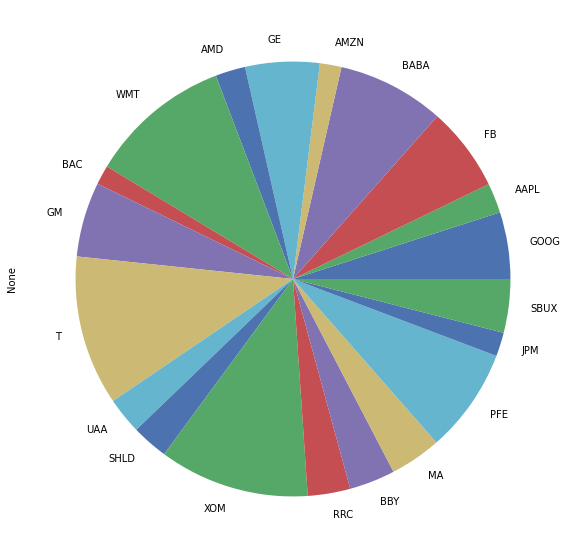

In [ ]:
pd.Series(weights).plot.pie(figsize=(10, 10));

In [ ]:
hrp.portfolio_performance(verbose=True);

Expected annual return: 21.4%
Annual volatility: 17.8%
Sharpe Ratio: 1.08


# Plotting for HRP

<Axes: >

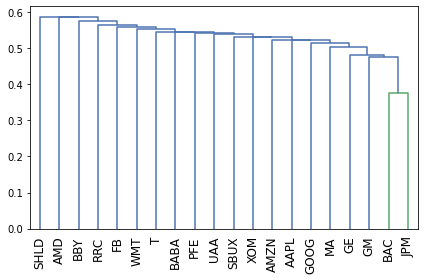

In [ ]:
from pypfopt import plotting

plotting.plot_dendrogram(hrp)